In [16]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import numpy as np
from tqdm import trange
import torch
import torch.nn.functional as F
# from torcheval.metrics.text import Perplexity
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from utils import load_model, Sampler, get_batch, configure_optimizers, time_gpu, get_pred_idxs

encoded = pickle.load(open('../cptData/llava/encoded.pkl', 'rb'))
img_idxs = pickle.load(open('../cptData/llava/img_idxs.pkl', 'rb'))
encoded_imgs = torch.load('../cptData/llava/all_features.pt')

train_data = encoded[:int(len(encoded)*0.9)]
val_data = encoded[int(len(encoded)*0.9):]
train_idxs = img_idxs[:int(len(img_idxs)*0.9)]
val_idxs = img_idxs[int(len(img_idxs)*0.9):]

In [18]:
def get_batch(i, train, device):
    if train:
        return torch.tensor(train_data[i], device=device), encoded_imgs[train_idxs[i]].to(device)
    else:
        return torch.tensor(val_data[i], device=device),  encoded_imgs[val_idxs[i]].to(device)
    
get_batch(0, False, 'cuda')[0]

tensor([  835,  2659, 29901,  1724,  1795,   367,   278,  7306,   470, 12091,
          310,   278,  2071,   631, 15859,   278, 12500, 29973,    13,  2277,
        29937, 29933,   327, 29901,  1576,  2071,   631, 15859,   278, 12500,
         1795,   367, 12242,   292,   304,  1510,  4878,  1009, 25078,   297,
        14911,   616,   767, 12932,   874,   470,  3763, 11418,  5414,   278,
         1468,   453,   310,   278, 12500, 29889,   739,   338,  1950,   393,
          896,   526,  5221,  1218,   297,   263, 14993,   292, 13888,   470,
         1741,   988, 14012,   432, 17204,   322,   380,   348,  1372,   526,
          760,   310,   278, 11780,   304,  6176,   263,  1880,  8158, 29889,
        20360, 29892,   896,  1122,   367,   263, 28709,  1288,  2071,   631,
        25738,   278, 29163,   322,   594,  1267,   284,   457,   364,  1878,
         6942,   411, 15859,   432, 17204,   373,   263,  1623, 29131,  3236,
        29889,   450,  2071,   631, 29915, 29879,  7306,   470, 

In [31]:
# !pip install open_clip_torch 
import open_clip
import torch
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
from tqdm import trange
import numpy as np
from utils import time_gpu

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [2]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-bigG-14', pretrained='laion2b_s39b_b160k')
print(sum(p.numel() for p in model.parameters() if p.requires_grad)/1e9)

2.539567105


In [3]:
model.to(torch.bfloat16)
device  = torch.device('cuda')
model = model.to(device)

In [108]:
pth = '../cptData/llava/train2014/COCO_train2014_000000482499.jpg'
pth2 = '../cptData/llava/train2014/COCO_train2014_000000517899.jpg'

# open image using PIL and print its size

print(Image.open(pth).size, Image.open(pth2).size)

## convert image to numpy array and print its size

img = np.array(Image.open(pth))
img2 = np.array(Image.open(pth2))

print(img.shape, img2.shape)

(375, 500) (631, 640)
(500, 375, 3) (640, 631)


In [9]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open('../cptData/llava/train2014/COCO_train2014_000000482499.jpg')).unsqueeze(0)
text = tokenizer(["a cave", "a cement bag", "a toilet"])

with torch.no_grad():
    image_features = model.encode_image(image.to(device).to(torch.bfloat16))
    text_features = model.encode_text(text.to(device))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

Label probs: tensor([[1.7643e-05, 5.0000e-01, 5.0000e-01]], device='cuda:0',
       dtype=torch.bfloat16)


In [1]:
import numpy as np
import sys
import os
import json
from tqdm import trange

pth = os.path.abspath(os.path.dirname(os.path.dirname(os.path.dirname("__file__"))))

print(pth)
###################################################################################################                          

## LLaVA-Instruct-150K

from datasets import load_dataset
dataset = load_dataset("liuhaotian/LLaVA-Instruct-150K")

/home/li/basu_workspace/nanoGPT


/home/li/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset json (/home/li/.cache/huggingface/datasets/liuhaotian___json/liuhaotian--LLaVA-Instruct-150K-1764f60a2e27bb0f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


In [15]:
import pickle

pth = '../cptData/llava/train2014'
dir_imgs = os.listdir(pth)

img_idxs = []
for i in trange(len(dataset['train'])):
    img = 'COCO_train2014_' + dataset['train'][i]['image']
    img_idxs.append(dir_imgs.index(img))

assert len(img_idxs) == len(dataset['train'])
    
pickle.dump(img_idxs, open('../cptData/llava/img_idxs.pkl', 'wb'))

100%|██████████| 394276/394276 [05:20<00:00, 1229.63it/s]


NameError: name 'pickle' is not defined

In [34]:
# data_cleaned = []

# for i in trange(len(dataset['train'])):
# # for i in range(12):
#     con = dataset['train'][i]['conversations']
#     con = "###User: " + con[0]['value'] + "\n###Bot:" + con[1]['value']
#     con = con.replace('<image>\n', '')
#     data_cleaned.append(con)
    
    
# sys.path.append(pth)
# from llamaTokenizer import LLaMAtokenizer

# tokenizer_path = os.path.join(os.path.dirname(pth), "cptData/lit-llama/tokenizer.model")

# train_frac = 0.9
# seq_len = 2048

# tokenizer = LLaMAtokenizer(model_path=tokenizer_path)
# enc = lambda s: tokenizer.encode(s, bos=False, eos=True)
# dec = lambda s: tokenizer.decode(s)

# encoded = [enc(data_cleaned[i]) for i in trange(len(data_cleaned))]
# assert len (encoded) == len(data_cleaned)

# encoded = [encoded[i] for i in range(len(encoded)) if len(encoded[i]) < seq_len]

# ## save encoded as pickle
# # import pickle
# # with open(os.path.join(pth, '../cptData/llava/encoded.pkl'), 'wb') as f:
# #     pickle.dump(encoded, f)

/home/li/basu_workspace/nanoGPT


Found cached dataset json (/home/li/.cache/huggingface/datasets/liuhaotian___json/liuhaotian--LLaVA-Instruct-150K-1764f60a2e27bb0f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 394276/394276 [02:02<00:00, 3228.28it/s] 


In [28]:
# imgs = []
# for i in trange(len(dataset['train'])):
#     imgs.append(dataset['train'][i]['image'])

100%|██████████| 394276/394276 [00:34<00:00, 11329.07it/s]


In [35]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")

totalTokens: 50.07 M


(array([1.52415e+05, 2.55800e+04, 1.30063e+05, 5.80320e+04, 1.36280e+04,
        7.91000e+03, 4.75800e+03, 1.55500e+03, 3.05000e+02, 3.00000e+01]),
 array([ 21. ,  75.2, 129.4, 183.6, 237.8, 292. , 346.2, 400.4, 454.6,
        508.8, 563. ]),
 <BarContainer object of 10 artists>)

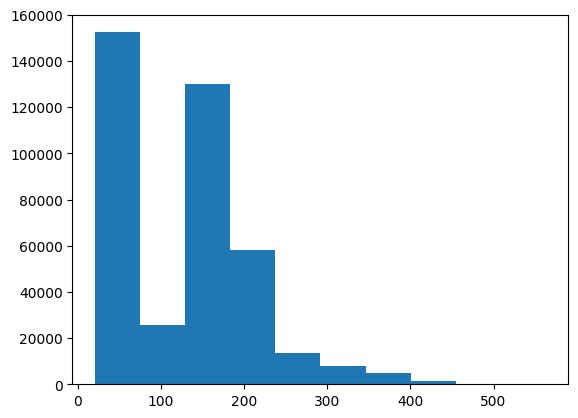

In [46]:
import matplotlib.pyplot as plt

lens = [len(i) for i in encoded]
lens = sorted(lens)
plt.hist(lens)

In [ ]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")


num_train = totalTokens//seq_len + 1

train_ids = encoded[:int(train_frac*len(encoded))]
val_ids = encoded[int(train_frac*len(encoded)):]
print("train_ids.shape: ", train_ids.shape)
print("val_ids.shape: ", val_ids.shape)

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)

train_ids.tofile(os.path.join(pth, 'data/{dataset}/train.bin'.format(dataset=dataset)))
val_ids.tofile(os.path.join(pth, 'data/{dataset}/val.bin'.format(dataset=dataset)))

In [38]:
## check if all imgs in llava dataset are in COCO

import os
import bisect
from tqdm import trange

imgs = os.listdir('/home/li/basu_workspace/cptData/train2014')
print(imgs[0])
de
imgs = [img[15:] for img in imgs]
imgs = sorted(imgs)


for i in trange(len(dataset['train'])):
    img = dataset['train'][i]['image']
    if bisect.bisect_left(imgs, img) == len(imgs) or imgs[bisect.bisect_left(imgs, img)] != img:
        print(img, i)
        raise ValueError('img not found')

COCO_train2014_000000482499.jpg


NameError: name 'de' is not defined

# Safe Tensors

In [ ]:
import torch
import safetensors
from safetensors.torch import save_model

save_model(model, 'my_model.safetensors')

# tensors = {}
# with safe_open("model.safetensors", framework="pt", device="cpu") as f:
#    for key in f.keys():
#        tensors[key] = f.get_tensor(key)

In [ ]:
import safetensors
safetensors.torch.load_model(model, 'my_model.safetensors')